# Programming assignment 3: Recurrent Neural Networks and Transformer Encoder

## Overview

<font size='4'>In this assignment you will practice putting together implementations of Recurrent Neural Networks, Transformer Encoder, and their applications to text classification. Especially for Transformer, you will get good understandings about foundations for very state-of-the-art models that you likely to see in tech news articles nowadays, like ChatGPT, Gemini.</font>

## Submission format

- <font size='4'>`<your_nu_username>_pa3.ipynb` with your implementations and output.</font>

## Note

<font size='4'>  

- Do not forget to choose to use GPU in the `Runtime\Change runtime type` tab.    
- **You are not allowed to look for answers online. Except for the links provided in this assignment, which are mainly about PyTorch documentation.**
- **Violation of this policy will lead to failure of your course and even more severe consequences.**
- Attend office hours and make post on Piazza if you have any questions.
</font>


## Setup

In [1]:
import sys
!{sys.executable} -m pip install numpy

import sys
print(sys.executable)
print(sys.version)


!which python
!which pip
!pip list | grep numpy

!/usr/local/bin/python -m pip install numpy



/usr/bin/python3
3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
/usr/local/bin/python
/usr/local/bin/pip
numpy                              1.24.0


In [29]:
# Step 1: Clean package cache and clear any conflicting installations
!pip cache purge
!rm -rf ~/.cache/torch
!rm -rf ~/.cache/pip

# Step 2: Uninstall existing versions of PyTorch and NumPy
!pip uninstall -y torch numpy

# Step 3: Reinstall compatible versions
!pip install numpy==1.24.0 torch==2.1.0

# Step 4: Check CUDA availability (if applicable)
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("CuDNN Enabled:", torch.backends.cudnn.enabled)

# Important: Restart the kernel after running this cell to apply changes.


Files removed: 0
Found existing installation: torch 2.1.0
Uninstalling torch-2.1.0:
  Successfully uninstalled torch-2.1.0
Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.0 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.24.0 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.24.0 which is incompatible.
seaborn 0.13.2 requires numpy!=1.24.0,>=1.20, but you have numpy 1.24.0 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.0 which i

CUDA Available: True
CUDA Version: 12.1
CuDNN Enabled: True


In [1]:
# Since torchtext has been deprecated, it is not compatible with the latest PyTorch version.
# We need to install an old version.
# Click to restart the session after the installation when you are prompted to do so.
!pip install portalocker==2.6.0
!pip install torch==2.1.0 torchtext==0.16.0
!pip install numpy



  Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.m

## Part 1: Text Classification with RNN (32 points)

In [2]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext.datasets import AG_NEWS
train_iter = AG_NEWS(split='train')

# Let's check what the data looks like
print('There are {} training samples in the training set.'.format(len(list(train_iter))))
# label, news content
print(next(iter(train_iter)))

There are 120000 training samples in the training set.
(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


### <font size='4' color='red'>Task 1.1: Implement a RNNCell (6 points)</font>

In [3]:
# Documentation of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class RNNCell(torch.nn.Module):
    """
    RNNCell is a single cell that takes x_t and h_{t_1} as input and outputs h_t.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of RNNCell.

        Inputs:
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """

        # We always need to do this step to properly implement the constructor
        super(RNNCell, self).__init__()

        self.linear_x, self.linear_h, self.non_linear = None, None, None

        ###########################################################################
        # TODO: Define the linear transformation layers for x_t and h_{t-1} and   #
        # the non-linear layer. You can use tanh here.                            #
        ###########################################################################
        self.linear_x = nn.Linear(input_dim, hidden_dim)
        self.linear_h = nn.Linear(hidden_dim, hidden_dim)
        self.non_linear = nn.Tanh()
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x_cur: torch.Tensor, h_prev: torch.Tensor):
        """
        Compute h_t given x_t and h_{t-1}.

        Inputs:
        - x_cur: x_t, a tensor with the shape of BxC, where B is the batch size and
          C is the channel dimension.
        - h_prev: h_{t-1}, a tensor with the shape of BxH, where H is the channel
          dimension.
        """
        h_cur = None
        ###########################################################################
        # TODO: Define the linear transformation layers for x_t and h_{t-1} and   #
        # the non-linear layer.                                                   #
        ###########################################################################
        h_cur = self.non_linear(self.linear_x(x_cur) + self.linear_h(h_prev))
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return h_cur


In [4]:
# Let's run a sanity check of your model
x = torch.randn((2, 8))
h = torch.randn((2, 16))
model = RNNCell(8, 16)
y = model(x, h)
assert len(y.shape) == 2 and y.shape[0] == 2 and y.shape[1] == 16
print(y.shape)

torch.Size([2, 16])


### <font size='4' color='red'>Task 1.2: Implement a single-layer (single-stack) RNN (6 points)</font>

In [5]:
class RNN(torch.nn.Module):
    """
    RNN is a single-layer (stack) RNN by connecting multiple RNNCell together in a single
    direction, where the input sequence is processed from left to right.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of the RNN module.

        Inputs:
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        ###########################################################################
        # TODO: Define the RNNCell.                                               #
        ###########################################################################
        self.rnn_cell = RNNCell(input_dim, hidden_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor):
        """
        Compute the hidden representations for every token in the input sequence.

        Input:
        - x: A tensor with the shape of BxLxC, where B is the batch size, L is the squence
          length, and C is the channel dimmension

        Return:
        - h: A tensor with the shape of BxLxH, where H is the hidden dimension of RNNCell
        """
        b = x.shape[0]
        seq_len = x.shape[1]

        # initialize the hidden dimension
        init_h = x.new_zeros((b, self.hidden_dim))

        h = None
        ###########################################################################
        # TODO: Compute the hidden representation for every token in the input    #
        # from left to right.                                                     #
        ###########################################################################
        h = torch.zeros((b, seq_len, self.hidden_dim), device=x.device)
        h_t = init_h

        for t in range(seq_len):
            h_t = self.rnn_cell(x[:, t, :], h_t)
            h[:, t, :] = h_t
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return h


In [6]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
model = RNN(8, 16)
y = model(x)
assert len(y.shape) == 3
for dim, dim_gt in zip(y.shape, [2, 10, 16]):
    assert dim == dim_gt
print(y.shape)

torch.Size([2, 10, 16])


### <font size='4' color='red'>Task 1.3: Implement a RNN-based text classifier (6 points)</font>

In [7]:
class RNNClassifier(nn.Module):
    """
    A RNN-based classifier for text classification. It first converts tokens into word embeddings.
    And then feeds the embeddings into a RNN, where the hidden representations of all tokens are
    then averaged to get a single embedding of the sentence. It will be used as input to a linear
    classifier.
    """
    def __init__(self,
            vocab_size: int, embed_dim: int, rnn_hidden_dim: int, num_class: int, pad_token: int
        ):
        """
        Constructor.

        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - rnn_hidden_dim: The hidden dimension of the RNN.
        - num_class: Number of classes.
        - pad_token: The index of the padding token.
        """
        super(RNNClassifier, self).__init__()

        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)

        self.rnn, self.fc = None, None

        ###########################################################################
        # TODO: Define the RNN and the classification layer.                      #
        ###########################################################################
        self.rnn = RNN(embed_dim, rnn_hidden_dim)
        self.fc = nn.Linear(rnn_hidden_dim, num_class)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        """
        Get classification scores (logits) of the input.

        Input:
        - text: Tensor with the shape of BxLxC.

        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """
        # get word embeddings
        embedded = self.embedding(text)

        logits = None
        ###########################################################################
        # TODO: Compute logits of the input.                                      #
        ###########################################################################
        rnn_output = self.rnn(embedded)
        sentence_embedding = rnn_output.mean(dim=1)
        logits = self.fc(sentence_embedding)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return logits


In [8]:
# Let's run a sanity check of your model
vocab_size = 10
embed_dim = 16
rnn_hidden_dim = 32
num_class = 3

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
print('x.shape: {}'.format(x.shape))
model = RNNClassifier(vocab_size, embed_dim, rnn_hidden_dim, num_class, 0)
y = model(x)
assert len(y.shape) == 2 and y.shape[0] == 2 and y.shape[1] == num_class
print(y.shape)

model = model.to('cuda:0')
x = x.to('cuda:0')
y = model(x)
print(y.shape, y.device)

x.shape: torch.Size([2, 10])
torch.Size([2, 3])
torch.Size([2, 3]) cuda:0


### Set up data related stuff

In [9]:
# check here for details https://github.com/pytorch/text/blob/main/torchtext/data/utils.py#L52-#L166
from torchtext.data.utils import get_tokenizer
# check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab_factory.py#L65-L113
from torchtext.vocab import build_vocab_from_iterator

# A tokenizer splits a input setence into a set of tokens, including those puncuation
# For example
# >>> tokens = tokenizer("You can now install TorchText using pip!")
# >>> tokens
# >>> ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']
tokenizer = get_tokenizer('basic_english')

train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Creates a vocab object which maps tokens to indices
# Check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab.py
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])

# The specified token will be returned when a out-of-vocabulary token is queried.
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

# The padding token we need to use
# The returned indices are always in an array
PAD_TOKEN = vocab(tokenizer('<pad>'))
assert len(PAD_TOKEN) == 1
PAD_TOKEN = PAD_TOKEN[0]

### <font size='4' color='red'>Task 1.4: Collate Batched Data with Data Loaders (5 points)</font>

In [10]:
# Documentation of DataLoader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader

# Merges a list of samples to form a mini-batch of Tensor(s)
def collate_batch(batch):
    """
    Input:
    - batch: A list of data in a mini batch, where the length denotes the batch size.
      The actual context depends on a particular dataset. In our case, each position
      contains a label and a Tensor (tokens in a sentence).

    Returns:
    - batched_label: A Tensor with the shape of (B,)
    - batched_text: A Tensor with the shape of (B, L), where L is the sequence length
    """
    label_list, text_list, text_len_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        text_len_list.append(processed_text.size(0))
    batched_label, batched_text = None, None
    ###########################################################################
    # TODO: Pad the text tensor in the mini batch so that they have the same  #
    # length. Specifically, you need to calculate the maximum length in the   #
    # batch and then add the token PAD_TOKEN to the end of those              #
    # shorter sentences.                                                      #
    ###########################################################################
    max_length = max(text_len_list)
    padded_text_list = [F.pad(text, (0, max_length - text.size(0)), value=PAD_TOKEN) for text in text_list]
    batched_label = torch.tensor(label_list, dtype=torch.int64)
    batched_text = torch.stack(padded_text_list)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return batched_label.long(), batched_text.long()

# Now, let's check what the batched data looks like
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)
for idx, (label, data) in enumerate(dataloader):
    if idx > 0:
        break
    print('label.shape: {}'.format(label.shape))
    print('label: {}'.format(label))
    print('data.shape: {}'.format(data.shape))


label.shape: torch.Size([8])
label: tensor([2, 2, 2, 2, 2, 2, 2, 2])
data.shape: torch.Size([8, 49])


### <font size='4' color='red'>Task 1.5: Functions of training for a single epoch and evaluation (5 points)</font>

In [11]:
import time

def train(model, dataloader, loss_func, optimizer, device, grad_norm_clip):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader):
        label = label.to(device)
        text = text.to(device)
        optimizer.zero_grad()

        logits = None
        ###########################################################################
        # TODO: compute the logits of the input, get the loss, and do the         #
        # gradient backpropagation.                                               #
        ###########################################################################
        logits = model(text)
        loss = loss_func(logits, label)
        loss.backward()
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        total_acc += (logits.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader, loss_func, device):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            label = label.to(device)
            text = text.to(device)

            logits = None
            ###########################################################################
            # TODO: compute the logits of the input, get the loss.                    #
            ###########################################################################
            logits = model(text)
            loss = loss_func(logits, label)
            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################

            total_acc += (logits.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count


In [14]:
!pip install --upgrade numpy torch

!pip uninstall -y torch numpy
!pip install torch numpy




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.6.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.6.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tenso

### <font size='4' color='red'>Task 1.6: Define the model, loss function, optimizer, and learning rate scheduler. You do not have to tune the hyperparameters here (our implementation is not optimal and thus slow). You should achieve 87% validation accuracy. (4 points)</font>

In [12]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# hyper parameters
epochs = 3 # epoch
lr = 0.0005 # learning rate
batch_size = 64 # batch size for training
word_embed_dim = 64
rnn_hidden_dim = 96

train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)

model, loss_func = None, None
###########################################################################
# TODO: Define the classifier, loss function, optimizer, and lr_scheduler.#
# You are encouraged to use the AdamW optimizer and find a suitable       #
# learning rate scheduler for it.                                         #
###########################################################################
model = RNNClassifier(
    vocab_size=vocab_size,
    embed_dim=word_embed_dim,
    rnn_hidden_dim=rnn_hidden_dim,
    num_class=num_class,
    pad_token=PAD_TOKEN
)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

# copy the model to the specified device (GPU)
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print('Number of parameters: {:.3f}K'.format(num_params / 1000))

total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train, split_valid = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train, batch_size=batch_size,
    shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    split_valid, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

# You should be able to get a validation accuracy around 87%
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, optimizer, device, 1)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


cuda
Number of parameters: 6147.844K
| epoch   1 |   500/ 1782 batches | accuracy    0.501
| epoch   1 |  1000/ 1782 batches | accuracy    0.685
| epoch   1 |  1500/ 1782 batches | accuracy    0.761
-----------------------------------------------------------
| end of epoch   1 | time: 111.45s | valid accuracy    0.802 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.823
| epoch   2 |  1000/ 1782 batches | accuracy    0.839
| epoch   2 |  1500/ 1782 batches | accuracy    0.857
-----------------------------------------------------------
| end of epoch   2 | time: 109.40s | valid accuracy    0.857 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.878
| epoch   3 |  1000/ 1782 batches | accuracy    0.888
| epoch   3 |  1500/ 1782 batches | accuracy    0.885
-----------------------------------------------------------
| end of epoch   3 | time: 111.05s | valid accuracy  

## Part 2: Text Classification with Transformer Encoder (68 points)

### <font size='4' color='red'>Task 2.1: Implement the multi-head attention module. No for are loops allowed. (15 points)</font>

In [28]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.

        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()

        assert input_dim % num_heads == 0

        self.input_dim = input_dim
        self.num_heads = num_heads
        # channel dimension per attention head
        self.dim_per_head = input_dim // num_heads

        ###########################################################################
        # TODO: Define the linear transformation layers for key, value, and query.#
        # Also define the output layer.                                            #
        ###########################################################################
        self.linear_q = nn.Linear(input_dim, input_dim)
        self.linear_k = nn.Linear(input_dim, input_dim)
        self.linear_v = nn.Linear(input_dim, input_dim)
        self.output_layer = nn.Linear(input_dim, input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.

        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]

        dot_prod_scores = None
        ###########################################################################
        # TODO: Compute the scores based on dot product between transformed query,#
        # key, and value. You may find torch.matmul helpful, whose documentation  #
        # can be found at                                                         #
        # https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul#
        # Remember to divide the dot product similarity scores by square root of  #
        # the channel dimension per head.                                          #
        #                                                                         #
        # Since no for loops are allowed here, think of how to use tensor reshape #
        # to process multiple attention heads at the same time.                    #
        ###########################################################################
        q = self.linear_q(query).view(b, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        k = self.linear_k(key).view(b, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        v = self.linear_v(value).view(b, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        dot_prod_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.dim_per_head)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        if mask is not None:
            # We simply set the similarity scores to be near negative infinity for
            # the positions where the attention should not be done. Think of why  #
            # we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        out = None
        ###########################################################################
        # TODO: Compute the attention scores, which are then used to modulate the #
        # value tensor. Finally concatenate the attended tensors from multiple    #
        # heads and feed it into the output layer. You may still find             #
        # torch.matmul helpful.                                                   #
        #                                                                         #
        # Again, think of how to use reshaping tensor to do the concatenation.    #
        ###########################################################################
        attention_scores = torch.softmax(dot_prod_scores, dim=-1)
        attended_values = torch.matmul(attention_scores, v)
        attended_values = attended_values.transpose(1, 2).contiguous().view(b, -1, self.input_dim)
        out = self.output_layer(attended_values)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return out


In [14]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = MultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.2: Implement a Feedforward Network (4 points)</font>

In [15]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()

        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.                 #
        ###########################################################################
        self.linear1 = nn.Linear(input_dim, ff_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension

        Return:
        - y: Tensor of the shape BxLxC
        """

        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################
        y = self.linear1(x)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.linear2(y)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [16]:
x = torch.randn((2, 10, 8))
ff_dim = 4
model = FeedForwardNetwork(8, ff_dim, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.3: Implement a single Transformer Encoder Cell using post layer normalization (15 points)</font>

In [29]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        ###########################################################################
        # TODO: A single Transformer encoder cell consists of
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm

        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################
        self.mha = MultiHeadAttention(input_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(input_dim)

        self.ffn = FeedForwardNetwork(input_dim, ff_dim, dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for masking in the multi-head attention
        """

        y = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts.                   #
        ###########################################################################
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        x = self.norm1(x + attn_output)


        ffn_output = self.ffn(x)
        ffn_output = self.dropout2(ffn_output)
        y = self.norm2(x + ffn_output)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [18]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.4: Implement Transformer Encoder (8 points)</font>

In [19]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()

        self.norm = None
        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TransformerEncoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList

        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        self.cells = nn.ModuleList([TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout) for _ in range(num_cells)])
        self.norm = nn.LayerNorm(input_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for masking in the multi-head attention

        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """

        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerEncoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################
        for cell in self.cells:
            x = cell(x, mask)
        y = self.norm(x)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [20]:
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoder(8, num_heads, 32, 2, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='red'>Task 2.5: Implement Positional Encoding (10 points)</font>

In [30]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        self.input_dim = input_dim

    def forward(self, x, max_length=10000):
        """
        Compute the positional encoding and add it to x.

        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - max_length: maximum sequence length the positional encoding can handle

        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]

        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel}) \\                        #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.                             #
        ###########################################################################
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_dim, 2).float() * -(math.log(max_length) / input_dim))
        pe = torch.zeros((seq_len, input_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        x = x + pe.to(x.device)
        return x


In [22]:
# Sanity check
x = torch.randn(1, 100, 20)
pe = PositionalEncoding(20)
y = pe(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y

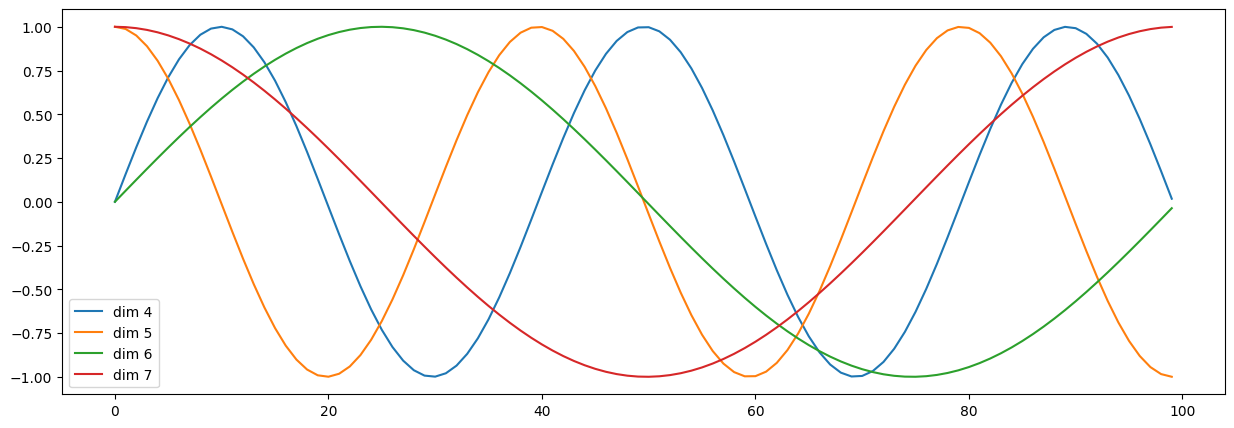

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward((torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

### <font size='4' color='red'>Task 2.6: Implement a Transformer-based Text Classifier (6 points)</font>

In [24]:
class TransformerClassifier(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self,
            vocab_size: int, embed_dim: int, num_heads: int, trx_ff_dim: int,
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=0
        ):
        """
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio
        - pad_token: The index of the padding token.
        """
        super(TransformerClassifier, self).__init__()

        self.embed_dim = embed_dim
        self.pad_token = pad_token

        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)

        ###########################################################################
        # TODO: Define a module for positional encoding, Transformer encoder, and #
        # an output layer                                                         #
        ###########################################################################
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.encoder = TransformerEncoder(embed_dim, num_heads, trx_ff_dim, num_trx_cells, dropout)
        self.output_layer = nn.Linear(embed_dim, num_class)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, text, mask=None):
        """
        Inputs:
        - text: Tensor with the shape of BxL, containing the indexes of each word in
          the vocabulary, which will be converted into word embeddings with the shape
          of BxLxC
        - mask: Tensor for masking in the multi-head attention

        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """

        # word embeddings, note we multiply the embeddings by a factor
        embedded = self.embedding(text) * math.sqrt(self.embed_dim)
        if mask is None:
            mask = (text != self.pad_token).unsqueeze(-2).unsqueeze(1)

        logits = None
        ###########################################################################
        # TODO: Apply positional embedding to the input, which is then fed into   #
        # the encoder. Average pooling is applied then to all the features of all #
        # tokens. Finally, the logits are computed based on the pooled features.  #
        ###########################################################################
        embedded = self.positional_encoding(embedded)
        encoded = self.encoder(embedded, mask)
        pooled = encoded.mean(dim=1)  # Average pooling over the sequence length
        logits = self.output_layer(pooled)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return logits


In [25]:
vocab_size = 10
embed_dim = 16
num_heads = 2
trx_ff_dim = 32
num_trx_cells = 2
num_class = 3

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
mask = (x != 0).unsqueeze(-2).unsqueeze(1)
model = TransformerClassifier(vocab_size, embed_dim, num_heads, trx_ff_dim, num_trx_cells, num_class)
print('x: {}, mask: {}'.format(x.shape, mask.shape))
y = model(x, mask)
assert len(y.shape) == 2 and y.shape[0] == x.shape[0] and y.shape[1] == num_class
print(y.shape)

x: torch.Size([2, 10]), mask: torch.Size([2, 1, 1, 10])
torch.Size([2, 3])


### <font size='4' color='red'>Task 2.7: Define the model, loss function, optimizer, and learning rate scheduler. And then tune the hyperparameters to train the model. You need to achieve 89% validation accuracy. (10 points)</font>

In [26]:
assert torch.cuda.is_available()
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameters
# Let's use a fixed number of epochs
epochs = 3 # epoch
###########################################################################
# TODO: Tune the hyper parameters
###########################################################################
# learning rate
lr = 0.0005
batch_size = 64
# dimension of word embedding dimension
word_embed_dim = 256
# feedforward hidden dimension
ff_dim = 512
# number of attention heads
num_heads = 8
# number of Transformer Encoder cells to stack
num_trx_cells = 6
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)

gradient_norm_clip = 10

model = None
loss_func = None
optimizer = None
scheduler = None
###########################################################################
# Define a Transformer-based text classifier, a loss function, optimizer, #
# and learning rate scheduler.                                            #
###########################################################################
model = TransformerClassifier(
    vocab_size=vocab_size,
    embed_dim=word_embed_dim,
    num_heads=num_heads,
    trx_ff_dim=ff_dim,
    num_trx_cells=num_trx_cells,
    num_class=num_class,
    dropout=0.1,
    pad_token=PAD_TOKEN
)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print('Number of parameters: {:.3f}K'.format(num_params / 1000))

num_params = sum(p.numel() for p in model.embedding.parameters())
print('Number of embedding parameters: {:.3f}K'.format(num_params / 1000))

# splits have been created in the RNN part
train_dataloader = DataLoader(
    split_train, batch_size=batch_size,
    shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    split_valid, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

total_accu = None

# You should be able to get a validation accuracy around 89%
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, optimizer, device, gradient_norm_clip)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    scheduler.step()
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


cuda
Number of parameters: 27691.780K
Number of embedding parameters: 24527.616K
| epoch   1 |   500/ 1782 batches | accuracy    0.767
| epoch   1 |  1000/ 1782 batches | accuracy    0.855
| epoch   1 |  1500/ 1782 batches | accuracy    0.869
-----------------------------------------------------------
| end of epoch   1 | time: 138.58s | valid accuracy    0.882 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.903
| epoch   2 |  1000/ 1782 batches | accuracy    0.902
| epoch   2 |  1500/ 1782 batches | accuracy    0.904
-----------------------------------------------------------
| end of epoch   2 | time: 139.41s | valid accuracy    0.894 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.925
| epoch   3 |  1000/ 1782 batches | accuracy    0.924
| epoch   3 |  1500/ 1782 batches | accuracy    0.918
-----------------------------------------------------------
| end of 

## <font color='red'> Part 3: Extra Credits: Image Classification with Transformer (14 points)

### <font size='4' color='red'>Implement VisionTransformer (ViT) for Image Classification. Train it on the CIFAR10 dataset (you may find the helper functions used in the previous programming assignment helpful). To get the full credits, you need to achieve 50% validation accuracy. No partial credits will be given if your accuracy is below 50%. Note the following comments and constraints:
- You need to implement a variant of the pre-norm Transformer cell shown in Fig. 1 of https://arxiv.org/pdf/2010.11929 (post-norm does not work well here).
- The number of parameters should be smaller than 3.2M.
- No pre-trained weights are allowed.
- Training has to finish within 3 epochs.
- Do not override any previous functions. Instead, re-implement a new one below if necessary.
</font>

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

class PreNormTransformerCell(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.dropout1(self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0])
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=256, depth=6, heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()
        self.patch_dim = (patch_size ** 2) * 3
        self.num_patches = (image_size // patch_size) ** 2
        self.linear_embedding = nn.Linear(self.patch_dim, dim)
        self.position_embeddings = nn.Parameter(torch.randn(1, self.num_patches, dim))
        self.transformer = nn.ModuleList([
            PreNormTransformerCell(dim, heads, mlp_dim, dropout) for _ in range(depth)
        ])
        self.classifier = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.reshape(B, C, H // 4, 4, W // 4, 4).permute(0, 2, 4, 3, 5, 1).reshape(B, -1, self.patch_dim)
        x = self.linear_embedding(x) + self.position_embeddings
        for layer in self.transformer:
            x = layer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

# Data preparation for CIFAR-10
def load_data(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Training and Evaluation

def train_vit(model, train_loader, val_loader, epochs=3, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_acc}%")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc}%")

    print("Training complete.")

train_loader, val_loader = load_data()
model = VisionTransformer()
train_vit(model, train_loader, val_loader)


AttributeError: module 'torch.library' has no attribute 'register_fake'